# Basic read and write operations

In this example we will explore how to create and read a simple Lightning Memory-Mapped Database (LMDB) using `pyxis`.

## Writing data

In [1]:
from __future__ import print_function

import time

import numpy as np

import pyxis as px

In [2]:
np.random.seed(1234)

Let's start by creating some data that we can store. `2000` images with shape `(254, 254, 3)` along with `2000` targets are generated.

In [3]:
nb_samples = 2000

X = np.zeros((nb_samples, 254, 254, 3), dtype=np.uint8)
y = np.arange(nb_samples, dtype=np.uint8)

The tenth image is set to be a completely red image.

In [4]:
X[10, :, :, 0] = 255

In the next step we instantiate a `pyxis` writer to write the data we created above to a directory called `data`.

In [5]:
db = px.Writer(dirpath='data', map_size_limit=500, ram_gb_limit=2)

The `map_size_limit` is the size of the LMDB in MB. For file systems running *ext4*, there is no big cost associated with making this big. `ram_size_limit` is the limit on how many GB of data we can push per write operation.

When the LMDB writer is set up, we can run the `pyxis.put_samples` function to write data. Ideally you should send large data blobs at once. Here we will write all the `2000` samples generated above at once. If the size of the data you have is larger than the size of your RAM, then you can perform multiple calls to `pyxis.put_samples`.

In [6]:
start = time.time()

db.put_samples('X', X, 'y', y)

print('Average time per image = {:.4f}s'.format((time.time() - start) / nb_samples))

Average time per image = 0.0016s


Data can be input in two different ways:

* `pyxis.put_samples('key1', value1, 'key2', value2, ...)`
* `pyxis.put_samples({'key1': value1, 'key2': value2, ...})`

The code example above uses the first option with alternating keys and values. The second option is simply a Python dictionary.

There are two requirements of data that is put in a `pyxis` database:

* All values must have the type `numpy.ndarray`.
* The first axis in all values must represent the sample number.

Make sure to close the LMDB environment after writing. The close operation makes sure to store the number of samples that has been written.

In [7]:
db.close()

## Reading data

In [8]:
try:
    %matplotlib inline
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('Could not import the matplotlib library required to '
                      'plot images. Please refer to http://matplotlib.org/ '
                      'for installation instructions.')

To read data from a LMDB we instantiate a `pyxis` reader using the directory of the database.

In [9]:
db = px.Reader('data')

All addressable keys can be found by calling the `pyxis.get_data_keys` function:

In [10]:
db.get_data_keys()

['X', 'y']

The `pyxis.get_sample` function can be used to retrieve an entire sample from the LMDB. The returned value is a Python dictionary, addressable by the keys used when writing the database.

In [11]:
sample = db.get_sample(10)
print('X: ', sample['X'].shape, sample['X'].dtype)
print('y: ', sample['y'].shape, sample['y'].dtype)

X:  (254, 254, 3) uint8
y:  () uint8


The code snippet above retrieves the tenth sample, i.e. the one with the red image.

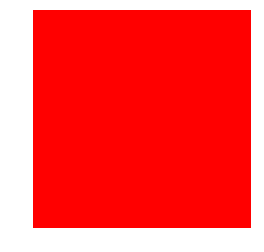

In [12]:
plt.figure()
plt.imshow(sample['X'])
plt.axis('off')
plt.show()

Data within a sample can be retrieved directly by using the `pyxis.get_data_value` function. Here we ask the LMDB for the hundredth `y` value.

In [13]:
db.get_data_value(100, 'y')

array(100, dtype=uint8)

Just like when writing, we should make sure to close the LMDB environment after we are done reading.

In [14]:
db.close()